# Book Recommendation system using K Nearest Neighbors
---

## Importing required libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

## Importing the Dataset
> The Dataset has been imported from the following Url
> <br>
> Dataset Url: http://www2.informatik.uni-freiburg.de/~cziegler/BX/

> ### Reading the dataset with some selected features

In [4]:
books = pd.read_csv('C:/Users/podug/Datasets/BX-CSV-DUMP/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

users = pd.read_csv('C:/Users/podug/Datasets/BX-CSV-DUMP/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

ratings = pd.read_csv('C:/Users/podug/Datasets/BX-CSV-DUMP/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


## Exploratory Data Analysis

In [5]:
print(ratings.shape)
print(list(ratings.columns))

(1149780, 3)
['userID', 'ISBN', 'bookRating']


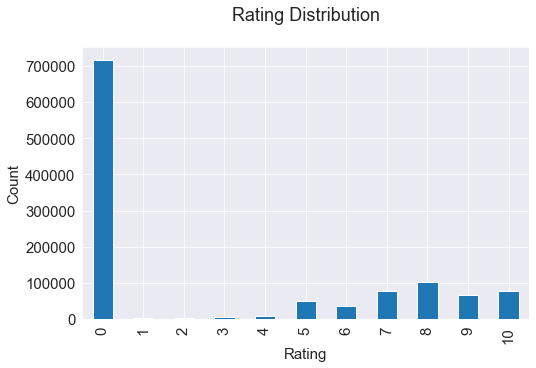

In [12]:
plt.rc("font", size=15)
plt.figure(figsize=(8, 5))
ratings.bookRating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [13]:
print(books.shape)
print(list(books.columns))

(271360, 8)
['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


In [14]:
print(users.shape)
print(list(users.columns))


(278858, 3)
['userID', 'Location', 'Age']


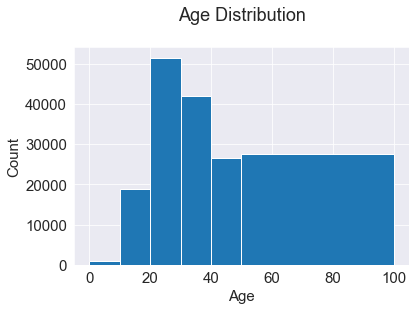

In [15]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig('system2.png', bbox_inches='tight')
plt.show()

### To ensure statistical significance, users with less than 200 ratings, and books with less than 100 ratings are excluded

In [18]:
counts1 = ratings['userID'].value_counts()
ratings = ratings[ratings['userID'].isin(counts1[counts1 >= 200].index)]
counts = ratings['bookRating'].value_counts()
ratings = ratings[ratings['bookRating'].isin(counts[counts >= 100].index)]

> ### Collaborative Filtering Using K Nearest Neighbors
> KNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors. For example, we first present ratings in a matrix with the matrix having one row for each intem(book) and one column for each user

In [19]:
combine_book_rating = ratings.merge(books, on = 'ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...


> We then group by book titles and create a new column for total rating count

In [20]:
combine_book_rating.shape

(488742, 4)

In [23]:
combine_book_rating = combine_book_rating.dropna(axis=0, subset = ['bookTitle'])
book_ratingCount = (combine_book_rating.groupby('bookTitle')['bookRating'].count().reset_index().rename(
    columns = {'bookRating': 'totalRatingCount'})[['bookTitle', 'totalRatingCount']])
book_ratingCount.head()

,bookTitle,totalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,2
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


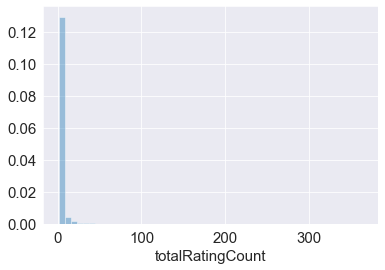

In [25]:
sns.distplot(book_ratingCount.totalRatingCount, norm_hist=True, kde=False)

> We merge the ratings data with the total rating count data, this gives us exactly what we need to find out which books are popular and filter out lesser-known books

In [28]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, on = 'bookTitle')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


In [32]:
rating_with_totalRatingCount.tail()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
488737,275970,1892145022,0,Here Is New York,1
488738,275970,1931868123,0,There's a Porcupine in My Outhouse: Misadventu...,1
488739,275970,3411086211,10,Die Biene.,1
488740,275970,3829021860,0,The Penis Book,1
488741,275970,4770019572,0,Musashi,1


In [33]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount.query('totalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82
2,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,82
3,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82
4,13552,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,82


In [34]:
rating_popular_book.shape

(62149, 5)

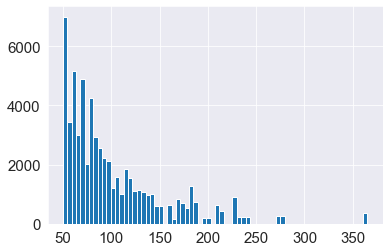

In [36]:
rating_popular_book.totalRatingCount.hist(bins=70)

### Considering Users from US and Canada
> Merging `rating_popular_book` and `users` datasets to filter the required users

In [38]:
combined = rating_popular_book.merge(users, on = 'userID')

us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]
us_canada_user_rating = us_canada_user_rating.drop('Age', axis=1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,82,"gilbert, arizona, usa"
1,277427,0060930535,0,The Poisonwood Bible: A Novel,133,"gilbert, arizona, usa"
2,277427,0060934417,0,Bel Canto: A Novel,108,"gilbert, arizona, usa"
3,277427,0061009059,9,One for the Money (Stephanie Plum Novels (Pape...,108,"gilbert, arizona, usa"
4,277427,006440188X,0,The Secret Garden,79,"gilbert, arizona, usa"


In [39]:
us_canada_user_rating.shape

(56396, 6)

## Cosine Similarity
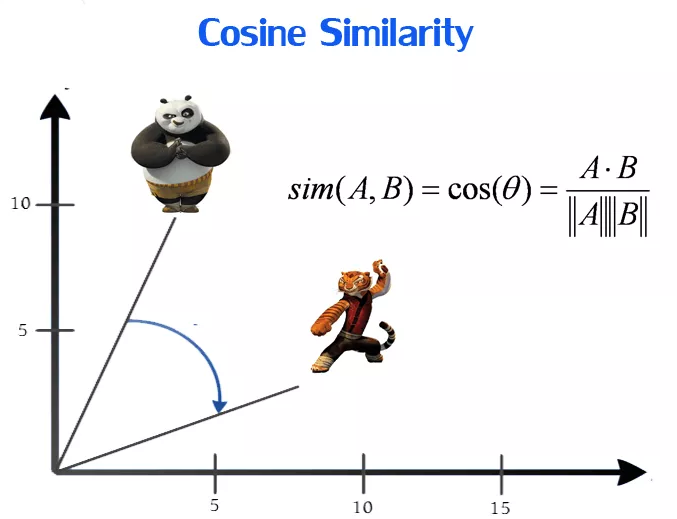

> ### Implementing kNN
> We convert our table to a 2D matrix, and fill the missing values with zeros (since we will calculate distances between rating vectors). We then transform the values(ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations.
> <br>
> <br>
> Finding the Nearest Neighbors We use unsupervised algorithms with sklearn.neighbors. The algorithm we use to compute the nearest neighbors is “brute”, and we specify “metric=cosine” so that the algorithm will calculate the cosine similarity between rating vectors. Finally, we fit the model.

In [40]:
from scipy.sparse import csr_matrix

us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

In [43]:
us_canada_user_rating_pivot.head()

userID,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,271448,271705,273979,274061,274308,274808,275970,277427,277639,278418
bookTitle,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
84 Charing Cross Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0


In [41]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [57]:
query_index = np.random.choice(us_canada_user_rating_pivot.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index, :].values.reshape(1, -1), 
                                          n_neighbors = 6)

3


In [58]:
us_canada_user_rating_pivot.index[query_index]

'4 Blondes'

In [59]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'Recommendations for {us_canada_user_rating_pivot.index[query_index]}: \n')
    else:
        print(f'{i} {us_canada_user_rating_pivot.index[indices.flatten()[i]]}, with distance of {distances.flatten()[i]}')
              

Recommendations for 4 Blondes: 

1 Seabiscuit, with distance of 0.7885540518910706
2 The Nanny Diaries: A Novel, with distance of 0.8188806433907103
3 The Carousel, with distance of 0.822061584547715
4 The Edge, with distance of 0.8221653992680177
5 Here on Earth, with distance of 0.8221823035560005


In [55]:
us_canada_user_rating_pivot.index[query_index]

'The Girl Who Loved Tom Gordon'

In [56]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'Recommendations for {us_canada_user_rating_pivot.index[query_index]}: \n')
    else:
        print(f'{i} {us_canada_user_rating_pivot.index[indices.flatten()[i]]}, with distance of {distances.flatten()[i]}')
              

Recommendations for The Girl Who Loved Tom Gordon: 

1 The Regulators, with distance of 0.5528840259448541
2 Rose Madder, with distance of 0.6384798302527743
3 Desperation, with distance of 0.6814566195271998
4 It, with distance of 0.6889743196849695
5 Four Past Midnight, with distance of 0.689082421786221
